In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
import time
import pandas as pd
import seaborn as sn
import keras
import os
import cv2
import pickle
import random
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid
from keras.preprocessing.image import ImageDataGenerator
# import matplotlib
# matplotlib.use("Agg")

Using TensorFlow backend.


In [2]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 300
INIT_LR = 1e-2
BS = 32
IMAGE_DIMS = (224, 224, 3)

In [3]:
from imutils import paths

imagePaths = sorted(list(paths.list_images("anger_classification")))
random.seed(42)
random.shuffle(imagePaths)
imagePaths

['anger_classification\\non_anger\\non_anger_143.jpg',
 'anger_classification\\non_anger\\non_anger_888.jpg',
 'anger_classification\\non_anger\\non_anger_737.jpg',
 'anger_classification\\non_anger\\non_anger_161.jpg',
 'anger_classification\\non_anger\\non_anger_2171.jpg',
 'anger_classification\\non_anger\\non_anger_1294.jpg',
 'anger_classification\\non_anger\\non_anger_1630.jpg',
 'anger_classification\\non_anger\\non_anger_427.jpg',
 'anger_classification\\non_anger\\non_anger_1039.jpg',
 'anger_classification\\non_anger\\non_anger_1054.jpg',
 'anger_classification\\non_anger\\non_anger_1827.jpg',
 'anger_classification\\non_anger\\non_anger_1946.jpg',
 'anger_classification\\non_anger\\non_anger_551.jpg',
 'anger_classification\\anger\\anger_444.jpg',
 'anger_classification\\non_anger\\non_anger_558.jpg',
 'anger_classification\\anger\\anger_459.jpg',
 'anger_classification\\non_anger\\non_anger_111.jpg',
 'anger_classification\\non_anger\\non_anger_632.jpg',
 'anger_classificat

In [4]:
from keras.preprocessing.image import img_to_array

data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [5]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 3542.11MB


In [6]:
from sklearn.preprocessing import LabelBinarizer

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [7]:
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

In [8]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [10]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16

print("[INFO] compiling model...")
model = VGG16()

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] done compiling.")

model.summary()

[INFO] compiling model...
[INFO] done compiling.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool 

In [11]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [12]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)#, class_weight={0:3, 1:1})

# save the model to disk
print("[INFO] serializing network...")
model.save("anger_imbalanced_VGG16_300_epochs.model")

[INFO] training network...
Epoch 1/300
75/75 [==============================] - 37s 498ms/step - loss: 69933340698.7340 - accuracy: 0.5642 - val_loss: 0.5890 - val_accuracy: 0.7280
Epoch 2/300
75/75 [==============================] - 25s 334ms/step - loss: 5.6276 - accuracy: 0.6340 - val_loss: 1.0120 - val_accuracy: 0.7280
Epoch 3/300
75/75 [==============================] - 25s 335ms/step - loss: 0.6676 - accuracy: 0.6992 - val_loss: 0.7662 - val_accuracy: 0.7280
Epoch 4/300
75/75 [==============================] - 25s 336ms/step - loss: 0.7058 - accuracy: 0.6672 - val_loss: 0.6230 - val_accuracy: 0.7280
Epoch 5/300
75/75 [==============================] - 25s 337ms/step - loss: 0.6082 - accuracy: 0.7270 - val_loss: 0.6397 - val_accuracy: 0.7280
Epoch 6/300
75/75 [==============================] - 25s 338ms/step - loss: 0.6266 - accuracy: 0.7169 - val_loss: 0.5901 - val_accuracy: 0.7280
Epoch 7/300
75/75 [==============================] - 25s 338ms/step - loss: 0.6093 - accuracy: 0.74

75/75 [==============================] - 25s 340ms/step - loss: 0.5840 - accuracy: 0.7354 - val_loss: 0.5858 - val_accuracy: 0.7280
Epoch 114/300
75/75 [==============================] - 26s 341ms/step - loss: 0.5760 - accuracy: 0.7400 - val_loss: 0.5976 - val_accuracy: 0.7280
Epoch 115/300
75/75 [==============================] - 25s 337ms/step - loss: 0.5595 - accuracy: 0.7536 - val_loss: 0.5853 - val_accuracy: 0.7280
Epoch 116/300
75/75 [==============================] - 26s 341ms/step - loss: 0.5751 - accuracy: 0.7400 - val_loss: 0.5856 - val_accuracy: 0.7280
Epoch 117/300
75/75 [==============================] - 26s 342ms/step - loss: 0.5717 - accuracy: 0.7430 - val_loss: 0.5854 - val_accuracy: 0.7280
Epoch 118/300
75/75 [==============================] - 26s 348ms/step - loss: 0.5745 - accuracy: 0.7425 - val_loss: 0.5854 - val_accuracy: 0.7280
Epoch 119/300
75/75 [==============================] - 26s 341ms/step - loss: 0.5696 - accuracy: 0.7463 - val_loss: 0.5854 - val_accuracy:

75/75 [==============================] - 26s 346ms/step - loss: 0.5718 - accuracy: 0.7442 - val_loss: 0.5858 - val_accuracy: 0.7280
Epoch 226/300
75/75 [==============================] - 26s 341ms/step - loss: 0.5646 - accuracy: 0.7484 - val_loss: 0.5856 - val_accuracy: 0.7280
Epoch 227/300
75/75 [==============================] - 26s 344ms/step - loss: 0.5701 - accuracy: 0.7425 - val_loss: 0.5876 - val_accuracy: 0.7280
Epoch 228/300
75/75 [==============================] - 26s 347ms/step - loss: 0.5727 - accuracy: 0.7430 - val_loss: 0.5858 - val_accuracy: 0.7280
Epoch 229/300
75/75 [==============================] - 26s 345ms/step - loss: 0.5698 - accuracy: 0.7430 - val_loss: 0.5856 - val_accuracy: 0.7280
Epoch 230/300
75/75 [==============================] - 26s 342ms/step - loss: 0.5693 - accuracy: 0.7438 - val_loss: 0.5853 - val_accuracy: 0.7280
Epoch 231/300
75/75 [==============================] - 32s 426ms/step - loss: 0.5659 - accuracy: 0.7480 - val_loss: 0.5858 - val_accuracy:

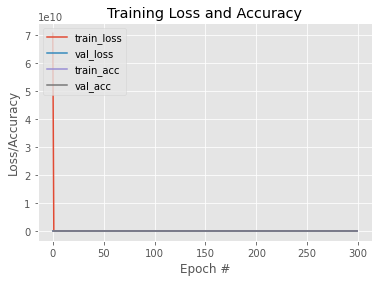

<Figure size 432x288 with 0 Axes>

In [13]:
plt.style.use("ggplot")
%matplotlib inline
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('anger_classification_imbalanced_VGG16_300_epochs.png', dpi=100)

In [19]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
 

# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)

Classification report: 
---------------------------------------------------------- 
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       164
   non-anger       0.73      1.00      0.84       439

    accuracy                           0.73       603
   macro avg       0.36      0.50      0.42       603
weighted avg       0.53      0.73      0.61       603

---------------------------------------------------------- 
Accuracy score: 0.728027
Precision score: 0.728027
Recall score: 1.000000
F1 score: 0.842610
---------------------------------------------------------- 
Confusion matrix: 
[[  0 164]
 [  0 439]]


C:\Users\tobby\Anaconda3\envs\russian_disinformation_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


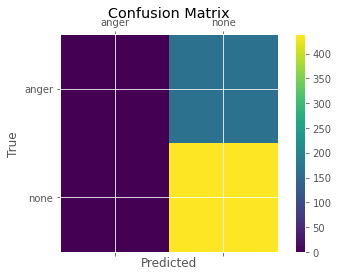

[[  0 164]
 [  0 439]]


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

classif_report = classification_report(testY, yhat_classes, target_names=['anger', 'non-anger'])
print('Classification report: ')
print('---------------------------------------------------------- ')
print(classif_report)

print('---------------------------------------------------------- ')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy score: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision score: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall score: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)
print('---------------------------------------------------------- ')

# confusion matrix
labels = ['anger', 'none']
matrix = confusion_matrix(testY, yhat_classes)
print('Confusion matrix: ')
print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_anger_imbalanced_VGG16_300_epochs.png')
plt.show()
print(matrix)